# 3.11. Entrenamiento modelo de corderos - Dataset 3

Vamos a entrenar un modelo de regresión lineal múltiple con el primer dataset obtenido.

En la siguiente línea de código, se importarán varias bibliotecas que brindan una amplia gama de herramientas para el análisis estadístico y el modelado de datos, así como para la visualización de los resultados.

- Pandas se utiliza para manejar los datos a través de estructuras más flexibles, en este caso, se trabajará con DataFrames.
- Numpy se usará para calcular la métrica RMSE y para ayudar con el gráfico 3D a través de sus funciones linspace para definir el rango de valores para dibujar el plano y meshgrid.
- Matplotlib y Seaborn se utilizarán para visualizar los resultados del entrenamiento mediante gráficos.
- Scikit-learn (sklearn) se usa para crear el modelo lineal. Train_test_split se utilizará para separar los datos en entrenamiento y prueba, y cross_val_score y KFold se utilizarán como formas de medir que el modelo funciona bien y no tiene mucho overfitting. Además, se utilizarán las siguientes métricas: mean_squared_error, r2_score, explained_variance_score y mean_absolute_error.
- Por último, se usará save_pickle para guardar el modelo entrenado.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

from statsmodels.iolib.smpickle import save_pickle

Lo siguiente que vamos a hacer es recuperar el dataset que tiene los datos por departamento de la producción y clima de Chubut.

In [2]:
dataset = pd.read_csv("../datos_analisis/dataset_produccion_clima_chubut_actualizado.csv")
dataset

,fecha,provincia,departamento,carneros,ovejas,borregos,capones,corderos_corderas,total_ovinos,kilos_lana,finura,rinde,humedad,cant_lluvia,tem_max,temp_media,temp_min
0,2012-12-31,CHUBUT,BIEDMA,2740,52320,22319,25489,29517,132385,478116.00,19.30,55.68,58.40,46.40,18.10,12.40,6.70
1,2013-12-31,CHUBUT,BIEDMA,3925,70677,27227,33389,36961,172179,544941.00,19.80,55.00,64.70,226.50,19.90,14.20,8.80
2,2014-12-31,CHUBUT,BIEDMA,3223,61195,29491,29688,34926,158523,513951.00,19.22,58.86,60.50,331.30,20.60,14.70,9.20
3,2015-12-31,CHUBUT,BIEDMA,3885,67528,28319,33296,38117,171145,540818.20,19.32,58.36,58.70,114.20,22.20,15.80,10.20
4,2016-12-31,CHUBUT,BIEDMA,3743,70451,30050,33038,37923,175205,606209.30,19.29,57.35,57.50,88.90,25.20,18.60,12.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2016-12-31,CHUBUT,TELSEN,4711,74125,28715,31728,31883,171162,665820.18,19.97,53.52,50.80,273.33,17.47,11.57,5.77
160,2017-12-31,CHUBUT,TELSEN,4496,71149,27574,28606,31987,163812,617571.24,20.00,52.95,47.17,220.03,16.60,10.93,5.03
161,2018-12-31,CHUBUT,TELSEN,4634,74179,28793,35979,28221,171806,627091.90,19.81,52.41,47.93,201.40,17.63,11.33,5.03
162,2019-12-31,CHUBUT,TELSEN,4305,72515,27648,35273,29417,169158,622501.44,19.87,53.99,47.57,119.47,17.53,11.17,4.83


## Predicción: Corderos

Variables independientes: 
- Cantidad total de lluvia acumulada de cada año (mm)
- Cantidad de ovejas

Variables dependientes:
- Cantidad de corderos

Empezamos extrayendo dos variables del conjunto de datos 'dataset', que se utilizarán posteriormente para la creación del modelo de regresión lineal.

La variable 'X_lluvia_ovejas' se crea seleccionando las columnas 'cant_lluvia' y 'ovejas' del conjunto de datos 'dataset', estas columnas se utilizan como variables independientes o predictores del modelo.

La variable 'y_corderos' se crea seleccionando la columna 'cordero/as' del conjunto de datos 'dataset', esta columna se utiliza como variable dependiente o respuesta del modelo.

In [3]:
X_lluvia_ovejas = dataset[['cant_lluvia', 'ovejas']]
y_corderos = dataset[['corderos_corderas']]

Lo siguiente es dividir los datos en dos conjuntos: uno para entrenamiento y otro para prueba. 
- X_train y y_train corresponden a los datos de entrenamiento que se utilizarán para ajustar el modelo.
- X_test y y_test corresponden a los datos de prueba que se utilizarán para evaluar el rendimiento del modelo.

La función `train_test_split` toma como entrada los datos originales, `X_lluvia_ovejas` y `y_corderos`, y divide aleatoriamente los datos en conjuntos de entrenamiento y prueba. El parámetro `test_size` indica el porcentaje de datos que se utilizarán para prueba (en este caso, el 20% de los datos) y `random_state` es una semilla que se utiliza para asegurar que los conjuntos de entrenamiento y prueba sean siempre los mismos en cada ejecución del código.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X_lluvia_ovejas, 
                                                y_corderos, 
                                                test_size=0.20,
                                                random_state=0
                                            )

Luego creamos un objeto `KFold` que se utiliza para realizar una validación cruzada en el conjunto de datos. La validación cruzada es una técnica que se utiliza para evaluar el rendimiento del modelo y estimar su capacidad para generalizar a nuevos datos. El objeto `KFold` divide el conjunto de datos en k partes iguales (en este caso, k=5), y utiliza cada una de ellas como conjunto de prueba y el resto como conjunto de entrenamiento. De esta manera, se obtiene una estimación del rendimiento del modelo en distintas combinaciones de entrenamiento y prueba.

Entonces para entrenar el modelo de manera más efectiva, utilizaremos el método `K-Folds` con 5 divisiones. Este enfoque consiste en iterar 5 veces, donde en cada iteración se separan 33 muestras para utilizarlas como conjunto de prueba, mientras que las 131 restantes se usan para entrenar el modelo. Luego se mide el rendimiento del modelo utilizando el conjunto de prueba apartado en cada iteración. Esto nos permite realizar 5 entrenamientos independientes y obtener 5 resultados de rendimiento. Finalmente, el rendimiento del modelo se calculará como el promedio de los 5 resultados obtenidos. De esta manera, evitamos sobrestimar el rendimiento del modelo al utilizar el mismo conjunto de prueba en todas las iteraciones.

In [5]:
kf = KFold(n_splits=5)

Luego de llevar a cabo estas 5 iteraciones, se espera obtener 5 puntuaciones (score) que sean cercanas entre sí, lo que servirá como **una señal de que el modelo está rindiendo bien y que tiene una buena capacidad de generalización**. Una vez completada esta fase de validación, el siguiente paso es crear el modelo y proceder a su entrenamiento con los datos.

In [6]:
model_corderos = linear_model.LinearRegression()
model_corderos.fit(X_train, y_train)

LinearRegression()

Se procede a comparar los resultados del modelo inicial de entrenamiento con los obtenidos en los 5 procesos de validación cruzada, a través del promedio de estos últimos. Es posible notar que existe una **coincidencia o similitud** entre los resultados. La métrica del modelo es de *0.97*, mientras que las métricas de la validación cruzada son [0.96, 0.99, 0.98, 0.96, 0.94], cuya media es de *0.97*.

In [7]:
score = model_corderos.score(X_train,y_train)
'Métrica del modelo en Train {:.2}'.format(score)

'Métrica del modelo en Train 0.97'

In [8]:
scores = cross_val_score(model_corderos, X_train, y_train, cv=kf)
scores_rounded = [round(score, 2) for score in scores]
'Métricas cross validation: {}'.format(scores_rounded)

'Métricas cross validation: [0.96, 0.99, 0.98, 0.96, 0.94]'

In [9]:
'Media de cross validation {:.2}'.format(scores.mean())

'Media de cross validation 0.97'

Finalmente, realizamos una predicción utilizando el conjunto de prueba y verificamos que también obtenemos un **buen puntaje de precisión o score**.

In [10]:
pred_model_corderos = model_corderos.predict(X_test)

In [11]:
score_pred = r2_score(y_test, pred_model_corderos)
'Metrica del modelo en Test {:.2%}'.format(score_pred)

'Metrica del modelo en Test 97.87%'

Entonces guardamos el modelo como candidato para utilizarlo en la aplicación web.

In [12]:
save_pickle(model_corderos,'modelos/modelo_prediccion_corderos_3')

### Métricas

#### Score

*Score*: El "score" es un método que se incluye en todos los algoritmos y proporciona el resultado de un criterio de evaluación por defecto para el problema al que están dirigidos. En el caso de una regresión lineal, el método score devuelve el coeficiente de determinación, también conocido como **R²**, que se define como el porcentaje de la varianza de la variable dependiente que puede ser explicada por la variable independiente. Esta métrica nos ayuda a evaluar la calidad de nuestro modelo y a compararlo con otros modelos. En general, cuanto mayor sea el valor de **R²**, mejor ajustado estará el modelo a los datos.

In [13]:
'Score del modelo en entrenamiento: {:.2%}'.format(model_corderos.score(X_train, y_train))  

'Score del modelo en entrenamiento: 97.45%'

*Interpretación:* Un **R²** de 0.9745 significa que el modelo explica el 97.45% de la variabilidad de la producción de corderos en función de la cantidad de lluvia y el total de ovejas. Es métrica una demasiado buena.

In [14]:
'Score del modelo en test: {:.2%}'.format(model_corderos.score(X_test, y_test))

'Score del modelo en test: 97.87%'

*Interpretación:* el modelo tiene una precisión del 97.87% al predecir los valores de la variable dependiente (en este caso, los corderos) utilizando los valores de las variables independientes (cantidad de lluvia y número total de ovejas) en el conjunto de datos de prueba. Es decir, el modelo puede explicar aproximadamente el 97.87% de la varianza en la variable dependiente con los datos que no ha visto antes. Es métrica una demasiado buena.

#### Varianza explicada

*Varianza explicada*: es una medida del porcentaje de la varianza de la variable de salida que es explicado por el modelo. Esta métrica evalúa la variación o dispersión de los puntos de datos, y la mejor puntuación posible es 1.0, lo que indica que el modelo explica perfectamente toda la variabilidad de los datos. Sin embargo, una puntuación muy alta en esta métrica también puede indicar un riesgo de overfitting, es decir, que el modelo se ajusta demasiado bien a los datos de entrenamiento y no generaliza bien a nuevos datos. En sklearn, se puede utilizar el método **explained_variance_score** para calcular esta métrica.

In [15]:
'Varianza Explicada: {:.2%}'.format(explained_variance_score(y_test, pred_model_corderos))

'Varianza Explicada: 97.87%'

*Interpretación:* En este caso, la varianza explicada del modelo de regresión lineal es del 97.87%, lo que indica que el modelo es capaz de explicar el 97.87% de la variabilidad observada en la variable de salida (corderos), en base a las variables de entrada proporcionadas (lluvia, total de ovejas). Una varianza explicada del 97.87% indica que el modelo es bueno para predecir la variable de salida en función de las variables de entrada sin llegar a indicar un sobreajuste. Es una métrica muy alta.

#### Error medio absoluto

*Error medio absoluto* (**MAE**): Es la media de las diferencias absolutas entre el valor objetivo y el predicho. Al no elevar al cuadrado, no penaliza los errores grandes, lo que la hace no muy sensible a valores anómalos, por lo que no es una métrica recomendable en modelos en los que se deba prestar atención a éstos. Mientras mas cercano a cero mejor. Dentro de sklearn el método es **mean_absolute_error**.

In [16]:
'MAE: {:.0f}'.format(mean_absolute_error(y_test, pred_model_corderos))

'MAE: 3752'

*Interpretación:* El valor obtenido de 3752 indica que, en promedio, el modelo se equivoca en esa cantidad al predecir los corderos producidos. Es decir, en promedio, las predicciones del modelo tienen un error absoluto medio de 3752 en relación al valor real de la producción de corderos. Una forma de interpretar esta métrica es pensar en el valor de la producción de corderos que se está analizando y evaluar si el error medio absoluto es aceptable en relación a ese valor, dado que estamos hablando de números altos en muchos casos el valor no es tan malo. Es una métrica relativamente buena.

#### Raíz cuadrada del MSE

*Raíz cuadrada de la media del error al cuadrado* (**RMSE**): Es igual a la raíz cuadrada de la métrica MSE, la cual es la media de las diferencias entre el valor objetivo y el predicho al cuadrado, y al elevar al cuadrado magnifica los errores grandes. La ventaja de RMSE es que presenta el error en las mismas unidades que la variable objetivo, lo que la hace más fácil de entender. Mientras mas cercano a cero mejor. Dentro de sklearn el método es **mean_squared_error** con `squared = False`.

In [18]:
'RMSE: {:.0f}'.format(mean_squared_error(y_test, pred_model_corderos, squared = False))

'RMSE: 5575'

*Interpretación:* En este caso, la raíz cuadrada del MSE de 5575 indica que, en promedio, la diferencia entre los valores predichos y los valores observados de corderos es de aproximadamente 5575. Es una métrica relativamente buena.

#### R cuadrado

*R cuadrado* (**R²**): es una métrica utilizada para evaluar la capacidad de un modelo para ajustarse a los datos de entrenamiento. A diferencia de otras métricas, R2 compara nuestro modelo con un modelo básico que siempre devuelve como predicción la media de los valores objetivo de entrenamiento. La comparación entre estos dos modelos se realiza en base a la media de los errores al cuadrado de cada modelo.

Es importante destacar que el resultado del coeficiente de determinación, es un valor que oscila entre menos infinito y 1, siendo 1 el valor máximo que puede tomar. Cuanto más cercano a 1 sea el valor de esta métrica, mayor será el ajuste del modelo a la variable que estamos intentando explicar. De forma inversa, cuanto más cerca de menos infinito, menos ajustado estará el modelo y, por tanto, menos fiable será. Esto se debe a que R2 refleja la proporción de la varianza total de la variable objetivo que es explicada por nuestro modelo.

En resumen, el valor de R2 nos proporciona una medida de la calidad del ajuste de nuestro modelo a los datos de entrenamiento, siendo un valor cercano a 1 deseable para garantizar una buena capacidad predictiva.

El coeficiente de determinación se puede calcular utilizando la función **r2_score** de la biblioteca sklearn. 

In [19]:
'R2: {:.2%}'.format(r2_score(y_test, pred_model_corderos))

'R2: 97.87%'

*Interpretación:* En este caso, el valor de R cuadrado es 97.87%, lo que significa que aproximadamente el 97.87% de la variación en los datos de corderos producidos se puede explicar por las variables independientes utilizadas en el modelo de regresión lineal. Entonces el modelo de regresión lineal explica en un 98% la variable de salida, en este caso los corderos. Es métrica una demasiado buena.

El problema del coeficiente de determinación, y razón por el cual surge el coeficiente de determinación ajustado, radica en que no penaliza la inclusión de variables explicativas no significativas. Es decir, si al modelo se añaden cinco variables explicativas que guardan poca relación con lo que se intenta predecir, el R cuadrado aumentará. Es por ello que muchos expertos económetras, estadísticos y matemáticos se oponen al uso del R cuadrado como medida representativa de la bondad del ajuste real.

#### R cuadrado ajustado

La fórmula del R cuadrado ajustado es como sigue: $R^2_{ajustado} = 1 - \frac{(n-1)}{n-k-1}*(1-R^2)$

Donde:
- $R^2$: coeficiente de determinación
- $n$: número de observaciones
- $k$: número de predictores (variables explicativas) en el modelo.

Se va a crear una función que aplique esta fórmula a los datos.

In [20]:
def r2_ajustado(n,k,r2):
    return round(1-((n-1)/(n-k-1))*(1-r2),4)

n = len(y_test)
k = 2
r2 = r2_score(y_test, pred_model_corderos)

'R2 ajustado: {:.2%}'.format(r2_ajustado(n,k,r2))

'R2 ajustado: 97.72%'

*Interpretación:* un R2 ajustado de 97.72% indica que el modelo explica aproximadamente el 97.72% de la variabilidad en la variable objetivo, teniendo en cuenta las variables explicativas incluidas en el modelo. Es decir, la bondad de ajuste es del 98% y por lo tanto el modelo explica en un 98% los corderos. Es métrica una demasiado buena.

### Gráficos predición de corderos

A continuación, se presentarán dos gráficos para visualizar el rendimiento del modelo de regresión lineal múltiple en la predicción de la producción de corderos. En primer lugar, se utilizará un gráfico de dispersión en 3D para representar la relación entre las variables de entrada y la variable de salida. En segundo lugar, se empleará un gráfico de líneas para comparar los valores reales de la producción de corderos con los valores predichos por el modelo. Esto permitirá una mejor comprensión del desempeño del modelo y de la precisión de las predicciones.

#### Gráfico regresión lineal múltiple

Recordemos que las variables, `X_lluvia_ovejas` y `y_corderos`, son subconjuntos del dataset original que contienen las columnas "cant_lluvia", "ovejas" y "cordero/as", respectivamente.

Lo siguiente es transformar el dataframe `X_lluvia_ovejas` en un arreglo numpy de dos dimensiones (2D) para poder ser utilizado en el modelo de regresión lineal.

La función `values` de un dataframe de pandas devuelve un arreglo numpy que representa los datos del dataframe, y `reshape` se utiliza para darle una nueva forma o dimensión al arreglo, en este caso convirtiéndolo en una matriz de dos columnas (una para cada variable predictora).

El parámetro `-1` en `reshape` indica a NumPy que calcule el número necesario de filas en función de los datos y de la cantidad de columnas especificadas, de tal manera que los datos originales del dataframe se mantengan.

In [21]:
X = X_lluvia_ovejas.values.reshape(-1,2)

Luego le asignamos a la variable `Y` la columna `'cordero/as'` del dataframe original dataset. Esto se hace para tener una variable separada que contenga solo la variable de salida (en este caso `'cordero/as'`) y poder usarla en las operaciones posteriores.

In [22]:
Y = y_corderos

La siguiente celda contiene líneas de código que crean una malla de puntos en 2D para hacer una visualización en 3D de la superficie de regresión del modelo.

- `x_pred = np.linspace(7.1, 1041.16, 30)` crea un array de 30 valores igualmente espaciados que van desde 7.1 hasta 1041.16, que representan los posibles valores de la variable `cant_lluvia`.

- `y_pred = np.linspace(21913, 345839, 30)` crea un array de 30 valores igualmente espaciados que van desde 21913 hasta 345839, que representan los posibles valores de la variable `ovejas`.

- `xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)` crea una malla de puntos en 2D a partir de los dos arrays anteriores, donde `xx_pred` representa los valores de `cant_lluvia` y `yy_pred` los valores de `ovejas`.

- `model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T` crea un array `model_viz` que contiene una lista de todas las posibles combinaciones de valores para `cant_lluvia` y `ovejas`, que será usado para hacer la predicción y graficar la superficie de regresión.

In [23]:
x_pred = np.linspace(7.1, 1041.16, 30) # range of cant_lluvia
y_pred = np.linspace(21913, 345839, 30)  # range of ovejas
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

La siguiente celda prepara los datos necesarios para visualizar el modelo de regresión lineal múltiple en un gráfico en 3D.

- `x = X[:, 0]` extrae todos los valores de la primera columna de X y los asigna a la variable x, que representará los valores de la variable independiente cant_lluvia.
- `y = X[:, 1]` extrae todos los valores de la segunda columna de X y los asigna a la variable y, que representará los valores de la variable independiente ovejas.
- `z = Y` asigna todos los valores de la variable dependiente cordero/as a la variable z, que representará la variable que se quiere predecir en función de las variables independientes x e y.

In [24]:
x = X[:, 0]
y = X[:, 1]
z = Y

El código `predicted = model_corderos.predict(model_viz)` utiliza el modelo de regresión lineal previamente entrenado (`model_corderos`) para hacer una predicción de los valores de salida (`cordero/as`) correspondientes a todas las combinaciones posibles de valores de entrada para cant_lluvia y ovejas que se encuentran en la malla de puntos en 2D (`model_viz`).

Esto se logra utilizando el método `predict` del objeto del modelo de regresión lineal, que toma como entrada una matriz `X` de características y devuelve una matriz de valores de salida predichos correspondientes a cada entrada. En este caso, la matriz `X` es la malla de puntos `model_viz` que contiene todas las posibles combinaciones de valores de `cant_lluvia` y `ovejas`. Los valores predichos se almacenan en la variable predicted.

In [25]:
predicted = model_corderos.predict(model_viz)

El código `r2 = model_corderos.score(X, Y)` calcula el coeficiente de determinación R² del modelo de regresión lineal, que como vimos antes, es una medida estadística que indica la proporción de la varianza de la variable dependiente (cordero/as) que es explicada por el modelo en función de las variables independientes (cant_lluvia y ovejas).

Este método toma como entrada una matriz de características X (en este caso, la matriz X que se creó anteriormente a partir de las variables cant_lluvia y ovejas) y una matriz de valores de salida Y (en este caso, la matriz Y que contiene los valores reales de cordero/as). Luego, compara los valores de salida predichos por el modelo para cada muestra de X con los valores reales correspondientes de Y, y devuelve un valor entre menos infinito y 1 que indica la calidad del ajuste del modelo.

Un valor de R² más cercano a 1 indica que el modelo explica una gran proporción de la varianza de la variable dependiente, lo que indica un mejor ajuste del modelo a los datos. En este caso, el valor de R² obtenido se almacena en la variable `r2`.

In [26]:
r2 = model_corderos.score(X, Y)

El siguiente código crea una figura con tres subplots en 3D utilizando la biblioteca Matplotlib. Cada subplot contiene una visualización de la superficie de regresión lineal para diferentes ángulos de vista.

En cada subplot, se hace una visualización de los datos de entrada y de los valores predichos por el modelo. Los datos de entrada se representan como puntos negros en el fondo, mientras que los valores predichos se representan como puntos azules en la superficie.

También se establecen las etiquetas de los ejes y los parámetros del locator para la ubicación de las etiquetas de los ejes.

Finalmente, se establecen las posiciones de vista de los subplots y se agrega un título a la figura que muestra el valor del coeficiente de determinación ($R^2$) obtenido del modelo.

La llamada a la función fig.tight_layout() se encarga de ajustar automáticamente los espacios entre los subplots para que no haya superposiciones.

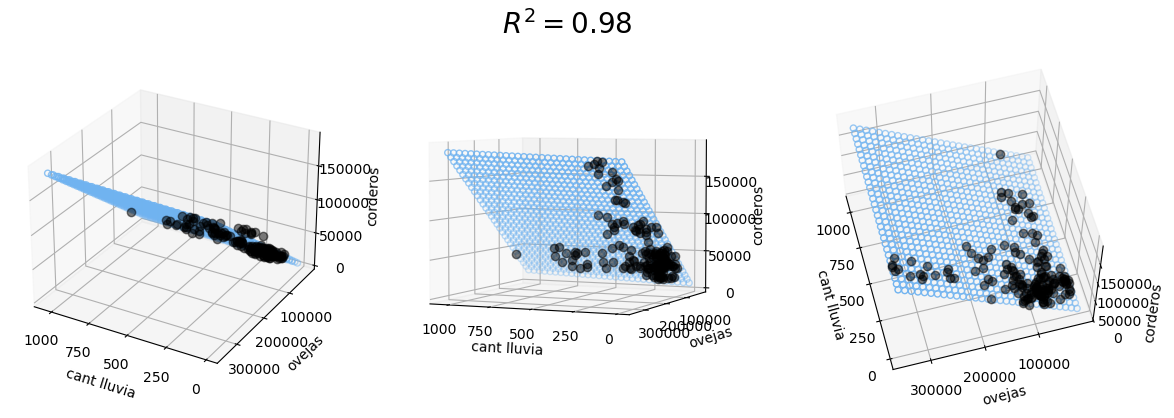

In [27]:
plt.style.use('default')
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    flattenX = x.flatten()
    flattenY = y.flatten()
    flattenZ = z.values.flatten()
    ax.plot(
        flattenX, flattenY, flattenZ, color='k', 
        zorder=15, linestyle='none', marker='o', alpha=0.5
    )
    ax.scatter(
        xx_pred.flatten(), yy_pred.flatten(), predicted, 
        facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0'
    )
    ax.set_xlabel('cant lluvia', fontsize=10)
    ax.set_ylabel('ovejas', fontsize=10)
    ax.set_zlabel('corderos', fontsize=10)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

Se observa que los datos no se ajustan perfectamente al plano, lo que va acorde con la información extraida de las métricas.

#### Gráfico predicción vs real

A continuación, se va a generar un gráfico 2D para comparar los datos reales con la predicción realizada por el modelo.

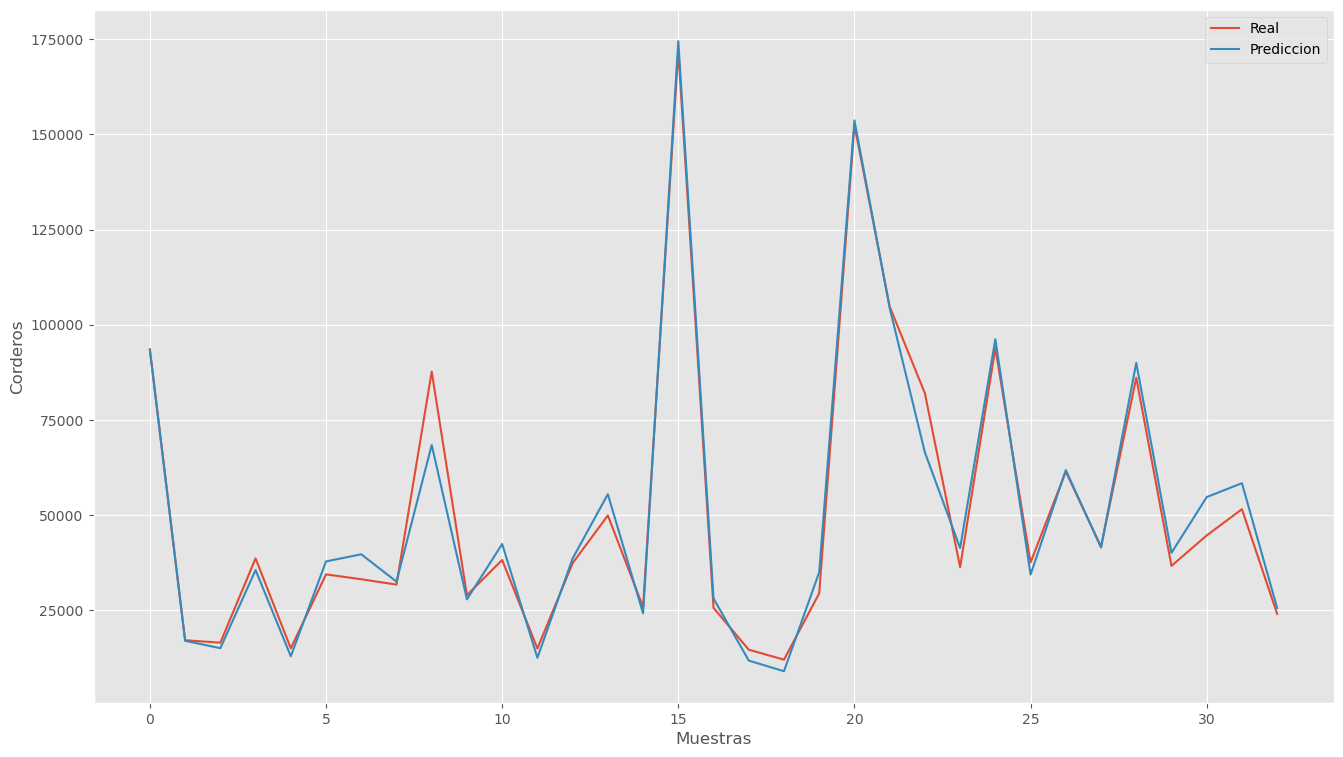

In [29]:
plt.plot(range(len(y_test)),y_test,label="Real")
plt.plot(range(len(pred_model_corderos)),pred_model_corderos,label="Prediccion")
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
plt.xlabel('Muestras')
plt.ylabel('Corderos')
plt.legend()
plt.show() 

Podemos observar que la línea roja que representa los valores reales y la línea azul que representa la predicción del modelo tienen una tendencia igual, casi sin desviaciones. Esto sugiere que el modelo está sobreajustando los datos de entrenamiento y es más probable que tenga un peor desempeño al predecir valores para nuevos datos.